In [1]:
import numpy as np
import scipy as sp
import math as ma
import qutip as qt
import matplotlib.pyplot as plt
import miscfuncs as mf
import pyplotsetup
%matplotlib inline

In [2]:
fockdim = 200

# Square GKP code stabiliser generators
alpha = np.sqrt(np.pi/np.sqrt(3))
beta = np.exp(2j*np.pi/3)*alpha  
Sx = mf.displacement_fock(2*alpha, fockdim)
Sz = mf.displacement_fock(2*beta, fockdim)

[Mx, My, Mz] = qt.qload('data/hex_measops_dim' + str(fockdim)) # Pauli-bin operators
a = qt.destroy(fockdim) # annihilation operator

Loaded list object.


In [3]:
def decode(state):
    if state.type == 'ket':
        rho = state*state.dag()
    else:
        rho = state
    return 0.5*(qt.qeye(2) + qt.expect(Mx, state)*qt.sigmax() + qt.expect(My,state)*qt.sigmay() 
            + qt.expect(Mz,state)*qt.sigmaz())

def squeezing(state, dB=True):
    if state.type == 'ket':
        rho = state*state.dag()
    else:
        rho = state
    Deltax = np.sqrt(-np.log(np.abs((Sx*rho).tr())**2)/(2*np.pi))
    Deltaz = np.sqrt(-np.log(np.abs((Sz*rho).tr())**2)/(2*np.pi))
    Delta = 0.5*(Deltax + Deltaz)
    if dB == True:
        return -10*np.log10(Delta**2)
    else:
        return Delta
    
# Driving functions
def SP(t, T, Deltat):
    if t%(T/6) < Deltat:
        return 3
    else:
        return 0

def HD(t, T, A):
    w = 2*np.pi/T # Driving frequency
    f = 0
    for n in range(len(A)):
        if n == 0:
            f += 0.5*A[n]
        else: 
            f += A[n]*np.cos(6*n*w*t)
    return f

In [4]:
def Floquet_states(w0, J, driving_function, args):
    if driving_function == 'SP':
        Deltat = args['Deltat'] # Pulse width
        T = 2*np.pi/w0 + 6*Deltat # Driving period
        
        # Define driving function
        def f(t, args):
            return SP(t, T, Deltat)
            
    elif driving_function == 'HD':
        A = args['A'] # Amplitudes
        T = 2*np.pi/w0 # Driving period
        
        # Define driving function
        def f(t, args):
            return HD(t, T, A)
    
    else:
        print('Invalid driving function. Options are `SP` for square pulse or `HD` for harmonic drive')
        return

    H0 = w0*a.dag()*a # HO potential
    H1 = -J*0.5*(Sx + Sx.dag()) # x cosine potential
    H = [H0, [H1, f]] # Driving Hamiltonian
    options = qt.Options(nsteps = 1e4) # Options for qt.sesolve
    U = qt.propagator(H, T, options = options) # Floquet operator
    eigenvals, states = U.eigenstates() # Diagonalise Floquet operator
    quasienergies = -np.angle(eigenvals)/T # Compute quasienergies from eigenvalues
    squeezings = [squeezing(state) for state in states]
    decoded_states = [decode(state) for state in states]
    
    return quasienergies, states, decoded_states, squeezings

In [5]:
def adiabatic_evolution(psi0, T_num, w0, J, driving_function, args, fast=True):
    if driving_function == 'SP':
        Deltat = args['Deltat'] # Pulse width
        T = 2*np.pi/w0 + 6*Deltat # Driving period
        options = qt.Options(nsteps = 1e6, max_step=0.1*Deltat) # Options for qt.sesolve
        
        # Define parameters for sigmoidal ramps
        wi = w0 # initial HO freq
        wf = w0 # final HO freq
        Ji = 0 # initial J
        Jf = J # final J
        kw = 20/T_num # slope of HO freq ramp
        kJ = 20/T_num # slope of J ramp
        tw = int(0.5*T_num) # center of HO freq ramp
        tJ = int(0.5*T_num) # center of J ramp
        
        # Define driving function
        def f(t, args):
            return SP(t, T, Deltat)
        
    elif driving_function == 'HD':
        A = args['A'] # Amplitudes for driving function
        w = w0 # Driving frequency
        T = 2*np.pi/w # Driving period
        options = qt.Options(nsteps = 1e5) # Options for qt.sesolve
        
        # Define parameters for sigmoidal ramps
        wi = 1 - np.pi*1e-3 # initial HO freq
        wf = w0 # final HO freq
        Ji = 0 # initial J
        Jf = J # final J
        kw = 30/T_num # slope of HO freq ramp
        kJ = 60/T_num # slope of J ramp
        tw = int(2/3*T_num) # center of HO freq ramp
        tJ = int(1/6*T_num) # center of J ramp
        
        # Define driving function
        def f(t, args):
            return HD(t, T, A)
        
    # Construct sigmoidal ramps
    C0w = (wf - wi) / ( (1 + np.exp(-kw*(T_num - tw)))**-1 - (1 + np.exp(kw*tw))**-1 )
    C1w = wi - C0w / (1 + np.exp(kw*tw))
    C0J = (Jf - Ji) / ( (1 + np.exp(-kJ*(T_num - tJ)))**-1 - (1 + np.exp(kJ*tJ))**-1 )
    C1J = Ji - C0J / (1 + np.exp(kJ*tJ))
    w0_list = C0w / (1 + np.exp(-kw*(np.linspace(0,T_num,T_num+1) - tw))) + C1w
    J_list = C0J / (1 + np.exp(-kJ*(np.linspace(0,T_num,T_num+1) - tJ))) + C1J
    
    if fast==True:
        # Time-dependent Hamiltonian coefficients
        def f0(t, args):
            w0_list = args['w0_list']
            return w0_list[round(t/T)]

        def f1(t, args):
            J_list = args['J_list']
            return J_list[round(t/T)]*f(t, args)

        # Do adiabatic evolution
        H0 = a.dag()*a # HO potential
        H1 = -0.5*(Sx + Sx.dag()) # x cosine potential
        H = [[H0, f0], [H1, f1]]
        t_list = np.linspace(0,T_num*T,T_num+1) # List of times
        result = qt.sesolve(H, psi0, t_list, args = {'w0_list':w0_list, 'J_list':J_list}, options=options) # Evolve initial state using the SE 
        return result.states # returns the evolved state at each period of the evolution
    
    if fast==False:
        U = []
        for i in range(T_num):
            H0 = w0_list[i]*a.dag()*a
            H1 = -J_list[i]*0.5*(Sx + Sx.dag())
            H = [H0, [H1, f]]
            options = qt.Options(nsteps=1e4)
            U.append(qt.propagator(H, T, options=options))
        
        # Do adiabatic evolution
        states = [psi0] 
        for i in range(len(U)):
            states.append(U[i]*states[i])
            
        return U, states # returns the Floquet operator and evolved state at each period of the evolution

In [6]:
quasienergies, states, decoded_states, squeezings = Floquet_states(0.05, 1, 'SP', args={'Deltat':0.1})

In [7]:
beta = 0.5*np.arccos(3**-0.5)
tplus = np.cos(beta)*qt.basis(2,0) + np.exp(1j*np.pi/4)*np.sin(beta)*qt.basis(2,1)
tminus = -np.sin(beta)*qt.basis(2,0) + np.exp(1j*np.pi/4)*np.cos(beta)*qt.basis(2,1)
fidelities_plus = []
fidelities_minus = []
for decoded_state in decoded_states:
    fidelities_plus.append(qt.fidelity(tplus, decoded_state))
    fidelities_minus.append(qt.fidelity(tminus, decoded_state))
GKP_floquet_states_SP = [states[np.argmax(fidelities_plus)], states[np.argmax(fidelities_minus)]]
decoded_GKP_floquet_states = [decoded_states[np.argmax(fidelities_plus)], decoded_states[np.argmax(fidelities_minus)]]
print(f'Logical infidelity with |T+>: {1-max(fidelities_plus):.2e}')
print(f'Logical infidelity with |T->: {1-max(fidelities_minus):.2e}')
print(f'Squeezings above 10 dB: {np.round(np.array(squeezings)[np.array(squeezings)>10], 2)}')

Logical infidelity with |T+>: 1.24e-06
Logical infidelity with |T->: 1.24e-06
Squeezings above 10 dB: [12.15 12.15]


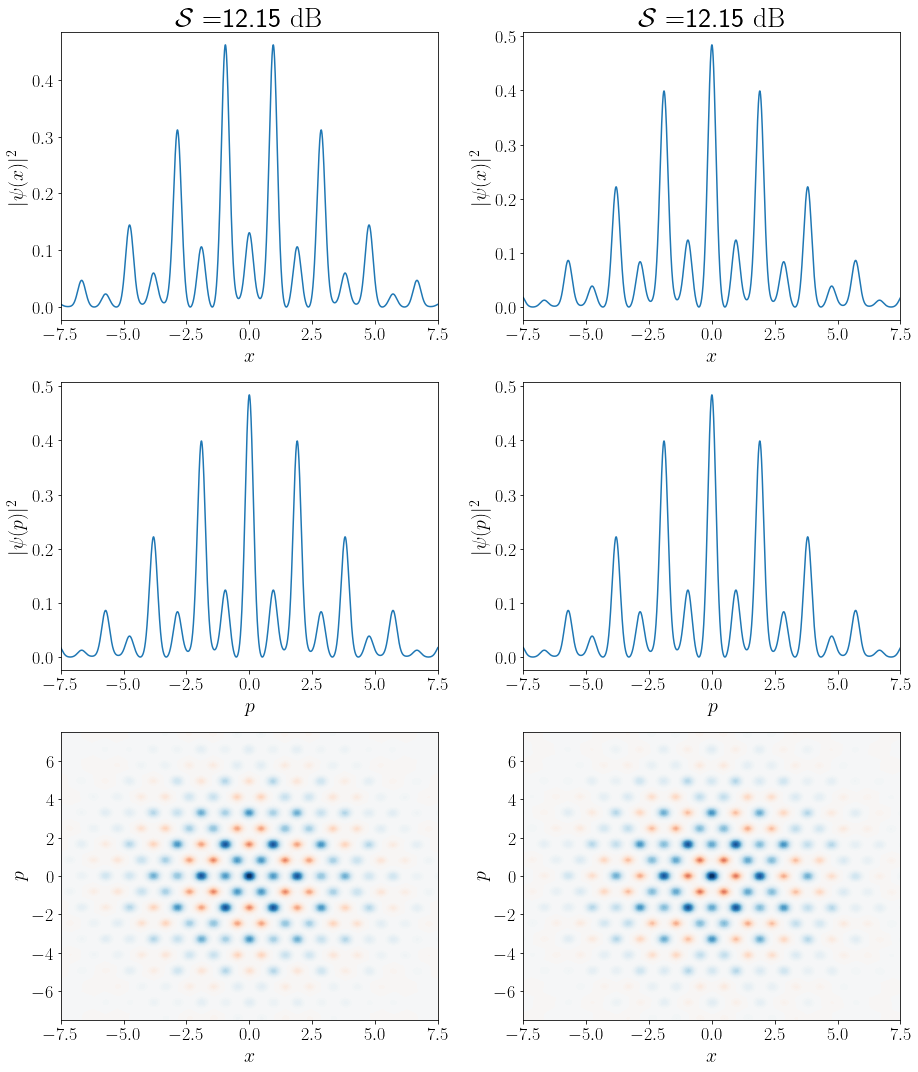

In [8]:
# Plot wavefunctions
qvalues = np.arange(-7.5, 7.5, 0.001)
xlims = [-7.5, 7.5]
fig, axs = plt.subplots(3, 2, figsize = (13,15))
for i in range(2):
    psix = mf.fock_to_pos(GKP_floquet_states_SP[i], qvalues, 0.0)
    axs[0,i].plot(qvalues, np.abs(psix)**2)
    axs[0,i].set_xlim(xlims)
    axs[0,i].set_xlabel(r'$x$')
    axs[0,i].set_ylabel(r'$|\psi (x)|^2$')
    axs[0,i].set_title(r'$\mathcal{S} = $'+str(round(np.sort(squeezings)[-i-1],2))+r'$~\mathrm{dB}$', fontsize=28)
for i in range(2):
    psip = mf.fock_to_pos(GKP_floquet_states_SP[i], qvalues, np.pi/2)
    axs[1,i].plot(qvalues, np.abs(psix)**2)
    axs[1,i].set_xlim(xlims)
    axs[1,i].set_xlabel(r'$p$')
    axs[1,i].set_ylabel(r'$|\psi (p)|^2$')
for i in range(2):
    qt.plot_wigner(GKP_floquet_states_SP[i],fig,axs[2,i])
    axs[2,i].set_title('')
    axs[2,i].set_xlim(xlims)
    axs[2,i].set_ylim(xlims)
    axs[2,i].set_xlabel(r'$x$', fontsize=20)
    axs[2,i].set_ylabel(r'$p$', fontsize=20)
plt.tight_layout()
plt.show()

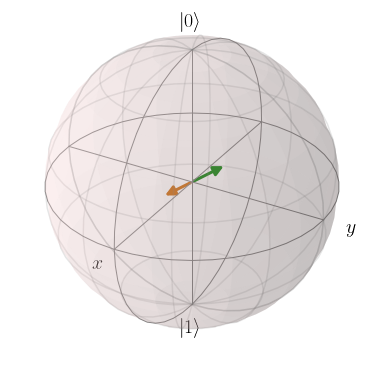

In [9]:
b = qt.Bloch()
b.add_states(decoded_GKP_floquet_states)
b.render()

In [10]:
quasienergies, states, decoded_states, squeezings = Floquet_states(1, 0.01, 'HD', args={'A':np.ones(3)})

In [11]:
fidelities_plus = []
fidelities_minus = []
for decoded_state in decoded_states:
    fidelities_plus.append(qt.fidelity(tplus, decoded_state))
    fidelities_minus.append(qt.fidelity(tminus, decoded_state))
GKP_floquet_states_HD = [states[np.argmax(fidelities_plus)], states[np.argmax(fidelities_minus)]]
decoded_GKP_floquet_states = [decoded_states[np.argmax(fidelities_plus)], decoded_states[np.argmax(fidelities_minus)]]
print(f'Logical infidelity with |T+>: {1-max(fidelities_plus):.2e}')
print(f'Logical infidelity with |T->: {1-max(fidelities_minus):.2e}')
print(f'Squeezings above 10 dB: {np.round(np.array(squeezings)[np.array(squeezings)>10], 2)}')

Logical infidelity with |T+>: 4.46e-03
Logical infidelity with |T->: 5.78e-03
Squeezings above 10 dB: [10.17 10.51]


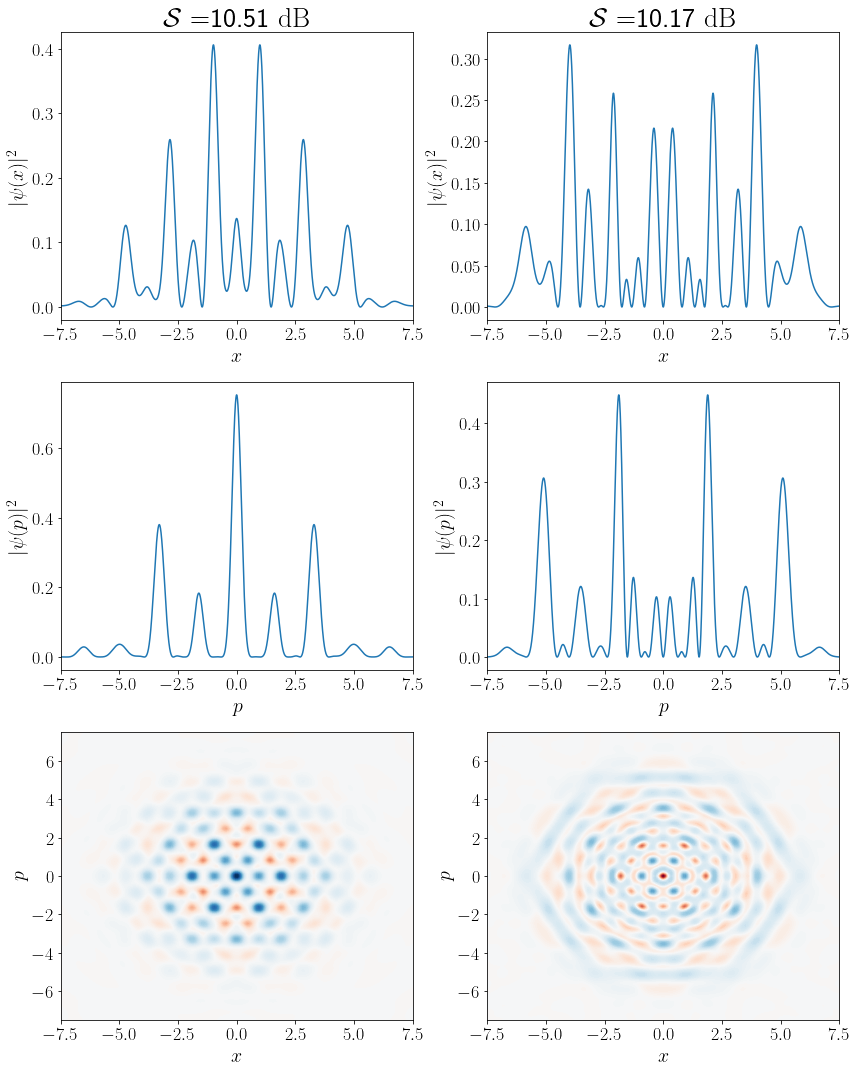

In [12]:
# Plot wavefunctions
qvalues = np.arange(-7.5, 7.5, 0.001)
xlims = [-7.5, 7.5]
fig, axs = plt.subplots(3, 2, figsize = (12,15))
for i in range(2):
    psix = mf.fock_to_pos(GKP_floquet_states_HD[i], qvalues, 0.0)
    axs[0,i].plot(qvalues, np.abs(psix)**2)
    axs[0,i].set_xlim(xlims)
    axs[0,i].set_xlabel(r'$x$')
    axs[0,i].set_ylabel(r'$|\psi (x)|^2$')
    axs[0,i].set_title(r'$\mathcal{S} = $'+str(round(np.sort(squeezings)[-i-1],2))+r'$~\mathrm{dB}$', fontsize=28)
for i in range(2):
    psip = mf.fock_to_pos(GKP_floquet_states_HD[i], qvalues, np.pi/2)
    axs[1,i].plot(qvalues, np.abs(psip)**2)
    axs[1,i].set_xlim(xlims)
    axs[1,i].set_xlabel(r'$p$')
    axs[1,i].set_ylabel(r'$|\psi (p)|^2$')
for i in range(2):
    qt.plot_wigner(GKP_floquet_states_HD[i],fig,axs[2,i])
    axs[2,i].set_title('')
    axs[2,i].set_xlim(xlims)
    axs[2,i].set_ylim(xlims)
    axs[2,i].set_xlabel(r'$x$', fontsize=20)
    axs[2,i].set_ylabel(r'$p$', fontsize=20)
plt.tight_layout()
plt.show()

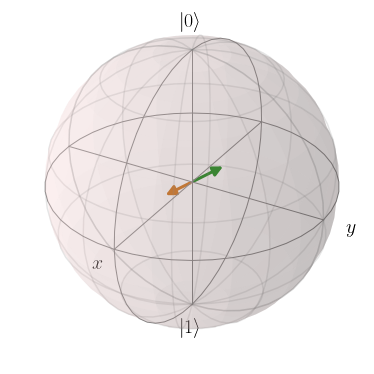

In [13]:
b = qt.Bloch()
b.add_states(decoded_GKP_floquet_states)
b.render()

In [14]:
states = adiabatic_evolution(qt.basis(fockdim, 0), 300, 0.05, 1, 'SP', {'Deltat':0.1})

In [15]:
qt.fidelity(states[-1], GKP_floquet_states_SP[0])

0.9991525085089936